In [1]:
pip install tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install yfinance pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [6]:
nvda_data = yf.download("NVDA", start="2024-01-01", end="2025-01-01", interval="1d")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [9]:
nvda_data.reset_index(inplace=True)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(nvda_data[['Close']])

In [13]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [15]:
time_step = 60
X, y = create_dataset(scaled_data, time_step)

In [17]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [19]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))

C:\Users\myern\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.4411
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1037
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0519
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0109
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0230
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0133
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0117
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0125
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0097
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0101


In [27]:
predictions = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 403ms/step


In [29]:
predictions = scaler.inverse_transform(predictions)

In [31]:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

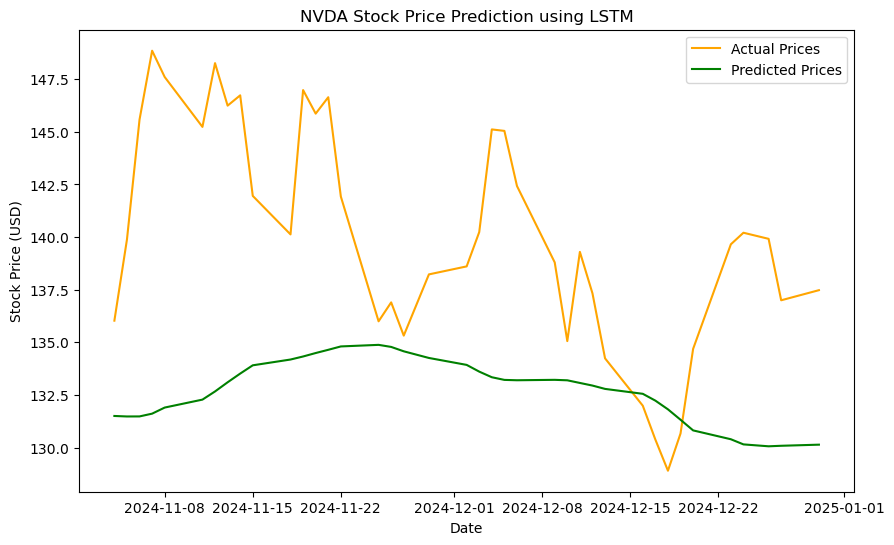

In [37]:
plt.figure(figsize=(10,6))
plt.plot(nvda_data['Date'].iloc[train_size + time_step:train_size + time_step + len(y_test_actual)], y_test_actual, label='Actual Prices', color='orange')
plt.plot(nvda_data['Date'].iloc[train_size + time_step:train_size + time_step + len(predictions)], predictions, label='Predicted Prices', color='green')
plt.title('NVDA Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()

In [39]:
forecast_dates = pd.date_range(start='2025-01-01', periods=len(predictions), freq='B')
forecast_df = pd.DataFrame(predictions, index=forecast_dates, columns=['Predicted Close'])
print(forecast_df.head())

            Predicted Close
2025-01-01       131.500000
2025-01-02       131.476242
2025-01-03       131.478470
2025-01-06       131.610199
2025-01-07       131.899445


In [41]:
from sklearn.metrics import mean_squared_error
import numpy as np
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 80.4638523300035


In [43]:
residuals = y_test_actual - predictions

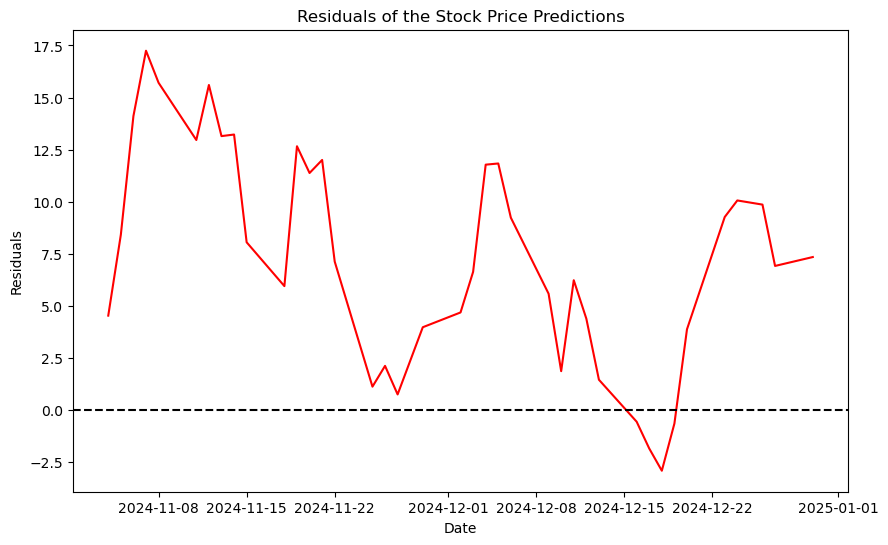

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(nvda_data['Date'].iloc[train_size + time_step:train_size + time_step + len(residuals)], residuals, color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals of the Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

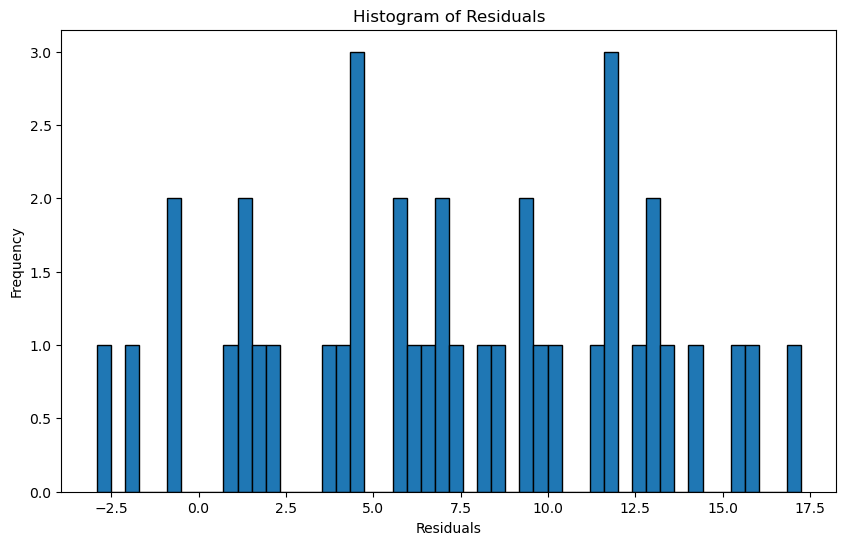

In [81]:
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Additional residual analysis includes the external factor of recent drops in the stock market, and it can be noted that some outliers should probably be removed.

In [91]:
pip install Prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   --- ------------------------------------ 1.0/13.3 MB 7.2 MB/s eta 0:00:02
   ------- -------------------------------- 2.6/13.3 MB 7.6 MB/s eta 0:00:02
   ------------- -------------------------- 4.5/13.3 MB 7.7 MB/s eta 0:00:02
   --------------------- ------------------ 7.1/13.3 MB 9.1 MB/s eta 0:00:01
   ---------------------------- ----------- 9.4/13.3 MB 9.3 MB/s eta 0:00:01
   ----------------------------------- ---- 11.8/13.3 MB 10.1 MB/s eta 0:00:01
   ---------------------------------------- 13.3/13.3 MB 9.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/863.9 kB ? eta -:--:--
   --------------------------------------- 863.9/863.9 kB 37.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [113]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

[*********************100%***********************]  1 of 1 completed


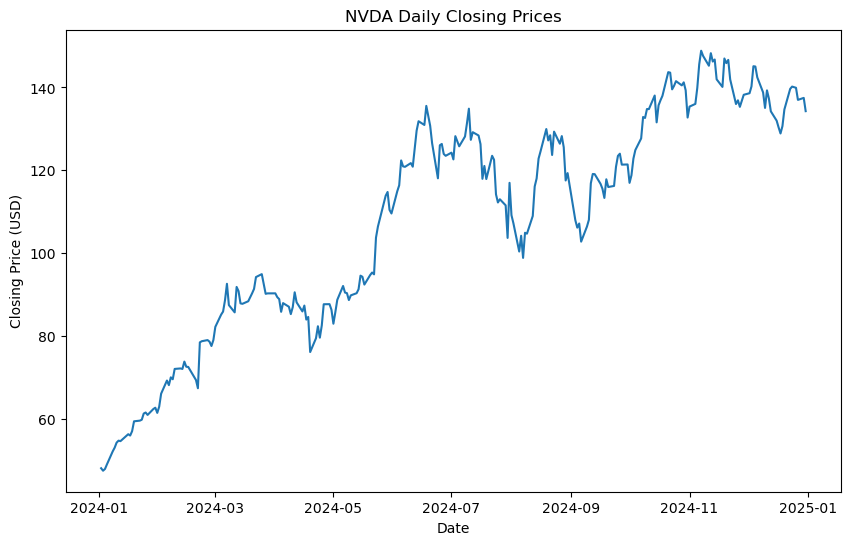

In [97]:
nvda_data = yf.download("NVDA", start="2024-01-01", end="2025-01-01", interval="1d")
nvda_data.reset_index(inplace=True)
nvda_data = nvda_data[['Date', 'Close']]
nvda_data.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
plt.figure(figsize=(10,6))
plt.plot(nvda_data['ds'], nvda_data['y'])
plt.title('NVDA Daily Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.show()

In [117]:
model = Prophet()

In [123]:
future = model.make_future_dataframe(nvda_data, periods=len(predictions), freq='B')

TypeError: Prophet.make_future_dataframe() got multiple values for argument 'periods'